# Evan Dietrich // Team 8


In [1]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns

## Pt One: Dropout-Risk Screen

### 1.1: Compute true/false positives/negatives.

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    length = len(ytrue_N) 
    for i in range(length): 
        if (ytrue_N[i] == 1 and yhat_N[i] == 1):
            TP = TP + 1.0
        if (ytrue_N[i] == 0 and yhat_N[i] == 0):
            TN = TN + 1.0   
        if (ytrue_N[i] == 0 and yhat_N[i] == 1):
            FP = FP + 1.0      
        if (ytrue_N[i] == 1 and yhat_N[i] == 0):
            FN = FN + 1.0   
    
    return TP, TN, FP, FN

In [3]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [4]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [5]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [6]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Functions for later use


In [7]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):

    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [8]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [9]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: hist of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Loading dataset

In [10]:
# 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_client/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_client/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_client/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [11]:
y_tr_M = np.loadtxt('./data_client/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_client/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_client/y_test.csv', delimiter=',', skiprows=1)

### 1.2: Computing fractional dropout


In [12]:
fractionDropInTrain = 0.0
fractionDropInValid = 0.0
fractionDropInTest = 0.0

countDropInTrain = 0.0
countDropInValid = 0.0
countDropInTest = 0.0

lengthDropTrain = len(y_tr_M) 
lengthDropValid = len(y_va_N)
lengthDropTest = len(y_te_N)

for i in range(lengthDropTrain): 
        if (y_tr_M[i] == 1):
            countDropInTrain = countDropInTrain + 1.0
            
fractionDropInTrain = (countDropInTrain / lengthDropTrain)            

for i in range(lengthDropValid): 
        if (y_va_N[i] == 1):
            countDropInValid = countDropInValid + 1.0 
            
fractionDropInValid = (countDropInValid / lengthDropValid)

for i in range(lengthDropTest): 
        if (y_te_N[i] == 1):
            countDropInTest = countDropInTest + 1.0 
            
fractionDropInTest = (countDropInTest / lengthDropTest)

print("Fraction with drop in TRAIN: %.3f" % fractionDropInTrain)
print("Fraction with drop in VALID: %.3f" % fractionDropInValid)
print("Fraction with drop in TEST : %.3f" % fractionDropInTest)

Fraction with drop in TRAIN: 0.141
Fraction with drop in VALID: 0.139
Fraction with drop in TEST : 0.139


### 1.3: Predict-0-always baseline

#### (a) Computes accuracy of the always-0 classifier.

In [13]:
# See how accurate our prediction is when it predicts always zero
# as there are a large number of zeros in the data set... our always-zero
# classifier should have a high % accuracy
lengthDropValid = len(y_va_N)

alwaysZeroCountValid = 0.0
alwaysZeroCountTest = 0.0

for i in range(lengthDropValid): 
        if (y_va_N[i] == 0):
            alwaysZeroCountValid = alwaysZeroCountValid + 1.0
            
accuracyOnValid = (alwaysZeroCountValid / lengthDropValid) 

for i in range(lengthDropTest): 
        if (y_te_N[i] == 0):
            alwaysZeroCountTest = alwaysZeroCountTest + 1.0 

accuracyOnTest = (alwaysZeroCountTest / lengthDropTest) 

print("Always-0: accuracy on VALID: %.3f" % accuracyOnValid)
print("Always-0: accuracy on TEST : %.3f" % accuracyOnTest)

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Confusion matrix for the always-0 classifier.

In [14]:
ytrue_N = y_va_N.copy()

hold_value = float(1 - accuracyOnValid)
yproba1_N = np.copy(ytrue_N)

for i in range(len(ytrue_N)):
    yproba1_N[i] = hold_value

# print(ytrue_N)
# print(yproba1_N)

thresh = 0.5

cm_df = calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh)
print(cm_df)

Predicted    0  1
True             
0          155  0
1           25  0


### 1.4: Logistic Regression

#### (a) Creating set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [15]:
tr_loss_list = list()
va_loss_list = list()

C_tr_used_list = list()
C_va_used_list = list()

##########################################
X = x_va_N2.copy()
y = y_va_N.copy()

def run_valid_loss(C):
    val = C
    C_va_used_list.append(C)
    clf_va = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X,y)
    result1 = clf_va.predict_proba(X)
    result1 = result1[:, 1]
    log_loss_valid = (sklearn.metrics.log_loss(y_va_N, result1))
    va_loss_list.append(log_loss_valid)

C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    val = 'none'
    run_valid_loss(C)
    
######
X2 = x_tr_M2.copy()
y2 = y_tr_M.copy()

def run_train_loss(C):
    val = C
    C_tr_used_list.append(C)
    clf_tr = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X2,y2)
    result2 = clf_tr.predict_proba(X2)
    result2 = result2[:, 1]
    log_loss_train = (sklearn.metrics.log_loss(y_tr_M, result2))
    tr_loss_list.append(log_loss_train)

C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    val = 'none'
    run_train_loss(C)

#### Plotting logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

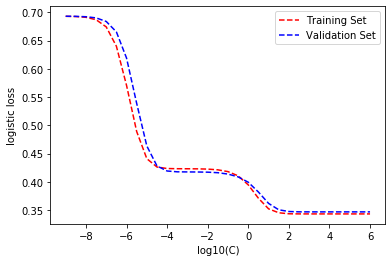

[1e-09, 3.1622776601683795e-09, 1e-08, 3.162277660168379e-08, 1e-07, 3.162277660168379e-07, 1e-06, 3.162277660168379e-06, 1e-05, 3.1622776601683795e-05, 0.0001, 0.00031622776601683794, 0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 31622.776601683792, 100000.0, 316227.7660168379, 1000000.0]
Best C-value for LR with 2-feature data: 1000000.0
Validation set log-loss at best C-value: 0.3433


In [16]:
# TODO make plot
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');

log10_C_tr_used_list = C_tr_used_list.copy()
log10_C_va_used_list = C_va_used_list.copy()

for idx in range(len(log10_C_tr_used_list)):
    hold_val = log10_C_tr_used_list[idx]
    new_val = np.log10(hold_val)
    log10_C_tr_used_list[idx] = new_val

for idx in range(len(log10_C_va_used_list)):
    hold_val = log10_C_va_used_list[idx]
    new_val = np.log10(hold_val)
    log10_C_va_used_list[idx] = new_val
    
# print(log10_C_tr_used_list)
plt.plot(log10_C_tr_used_list, tr_loss_list,'r--', log10_C_va_used_list, va_loss_list, 'b--')
plt.legend(['Training Set','Validation Set'])
plt.show()

print(C_va_used_list)

C_val = C_va_used_list[-1]
best_val = tr_loss_list[-1]

# print(C_val)
# print(best_val)

# last element of either tr_loss_list or va_loss_list
# TODO add legend
# plt.legend(...);

print("Best C-value for LR with 2-feature data: %.1f" % C_val) # TODO
print("Validation set log-loss at best C-value: %.4f" % best_val)

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

In [17]:
C = C_val
# print(C)
def run2_valid_loss(C):
    val = C
    C_va_used_list.append(C)
    clf_va = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X,y)
    resultnew1 = clf_va.predict_proba(X)
    resultnew1 = resultnew1[:, 1]
    return resultnew1

resultnew1 = run2_valid_loss(C)

# print(len(resultnew1))

# make_plot_perf_vs_threshold(ytrue_N, resultnew1, bin_edges=np.linspace(0, 1, 21))

#### (c) Model fitting with 3-feature data

Repeating model generation from **1.4 (a)**, using full 3-feature data.

In [18]:
X = x_va_N3.copy()
y = y_va_N.copy()

X2 = x_tr_M3.copy()
y2 = y_tr_M.copy()

tr3_loss_list = list()
va3_loss_list = list()

C3_tr_used_list = list()
C3_va_used_list = list()

##########################################
def run_valid_loss3(C):
    val = C
    C3_va_used_list.append(C)
    clf_va = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X,y)
    result1 = clf_va.predict_proba(X)
    result1 = result1[:, 1]
    log_loss_valid = (sklearn.metrics.log_loss(y_va_N, result1))
    va3_loss_list.append(log_loss_valid)
    
C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    val = 'none'
    run_valid_loss3(C)

##########################################
def run_train_loss3(C):
    val = C
    C3_tr_used_list.append(C)
    clf_tr = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X2,y2)
    result2 = clf_tr.predict_proba(X2)
    result2 = result2[:, 1]
    log_loss_train = (sklearn.metrics.log_loss(y_tr_M, result2))
    tr3_loss_list.append(log_loss_train)

C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    val = 'none'
    run_train_loss3(C)

##########################################

#### Plotting logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

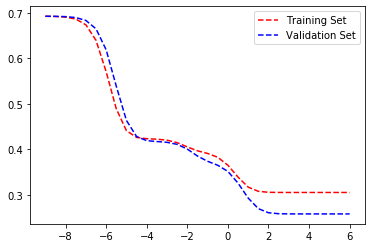

Best C-value for LR with 3-feature data: 1000000.000
Validation set log-loss at best C-value: 0.2577


In [19]:
log103_C_tr_used_list = C3_tr_used_list.copy()
log103_C_va_used_list = C3_va_used_list.copy()

for idx in range(len(log103_C_tr_used_list)):
    hold_val = log103_C_tr_used_list[idx]
    new_val = np.log10(hold_val)
    log103_C_tr_used_list[idx] = new_val

for idx in range(len(log103_C_va_used_list)):
    hold_val = log103_C_va_used_list[idx]
    new_val = np.log10(hold_val)
    log103_C_va_used_list[idx] = new_val
    
plt.plot(log103_C_tr_used_list, tr3_loss_list,'r--', log103_C_va_used_list, va3_loss_list, 'b--')
plt.legend(['Training Set','Validation Set'])
plt.show()

C_val = C3_va_used_list[-1]
best_val = va3_loss_list[-1]

print("Best C-value for LR with 3-feature data: %.3f" % C_val) # TODO
print("Validation set log-loss at best C-value: %.4f" % best_val)

#### Plotting performance of predictions made by the best 3-valued classifier on the validation set.

In [20]:
C = C_val
def run3_valid_loss(C):
    val = C
    C3_va_used_list.append(C)
    clf_va = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X,y)
    resultnew1 = clf_va.predict_proba(X)
    resultnew1 = resultnew1[:, 1]
    return resultnew1

resultnew1 = run3_valid_loss(C)

# make_plot_perf_vs_threshold(ytrue_N, resultnew1, bin_edges=np.linspace(0, 1, 21))

### 1.5: ROC Curves

Curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plotting ROC curves on the validation set.

Two curves in the plot, one for each of the best two classifiers from prior steps.

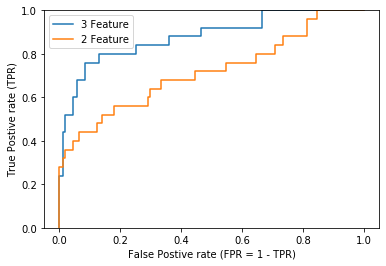

In [21]:
y3_3 = y_va_N.copy()

X = x_va_N3.copy()
y = y_va_N.copy()

C = 1000000
def run_valid_loss33(C):
    val = C
    clf_vat = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X,y)
    result1 = clf_vat.predict_proba(X)
    result1 = result1[:, 1]
    return result1

newy_3 = run_valid_loss33(C)
fpr, tpr, thr = sklearn.metrics.roc_curve(y3_3 ,newy_3) # (y_true, y_score)

plt.plot(fpr, tpr)
######################################

# y22 = y_tr_M.copy()
y3_3 = y_va_N.copy()

X5 = x_va_N2.copy()
y5 = y_va_N.copy()

C = 1000000

def run_valid_loss333(C):
    val = C
    clf_va = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X5,y5)
    result2 = clf_va.predict_proba(X5)
    result2 = result2[:, 1]
    return result2

newy_2 = run_valid_loss333(C)
fpr2, tpr2, thr2 = sklearn.metrics.roc_curve(y3_3 ,newy_2)

plt.plot(fpr2, tpr2)
plt.legend(['3 Feature','2 Feature'])

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

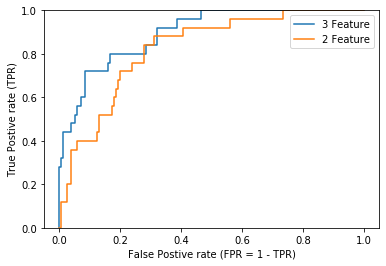

In [22]:
y3_3 = y_te_N.copy()

X = x_te_N3.copy()
y = y_te_N.copy()

C = 1000000
def run_valid_loss33(C):
    val = C
    clf_vat = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X,y)
    result1 = clf_vat.predict_proba(X)
    result1 = result1[:, 1]
    return result1

newy_3 = run_valid_loss33(C)
fpr, tpr, thr = sklearn.metrics.roc_curve(y3_3 ,newy_3)

plt.plot(fpr, tpr)
######################################

y3_3 = y_te_N.copy()


X5 = x_te_N2.copy()
y5 = y_te_N.copy()

C = 1000000

def run_valid_loss333(C):
    val = C
    clf_va = sklearn.linear_model.LogisticRegression(C = val, solver = 'liblinear').fit(X5,y5)
    result2 = clf_va.predict_proba(X5)
    result2 = result2[:, 1]
    return result2

newy_2 = run_valid_loss333(C)
fpr2, tpr2, thr2 = sklearn.metrics.roc_curve(y3_3 ,newy_2)

plt.plot(fpr2, tpr2)
plt.legend(['3 Feature','2 Feature'])

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

#### (c) Analyzing results shown to compare classifier performance.

With nearly the entirety of the 3 Feature Model having greater accuracy than the 2 Feature Model examples (in both the Validation and Test Sets), it would be fair to say that the 3 Feature Model serves as a better predictive metric for the Drop Dataset in determining which users are likely to drop.

### 1.6: Selecting a decision threshold

#### (a) Using default 0.5


In [23]:
best_thr = 0.5

ytrue_N = y_te_N.copy()
yproba1_N = newy_3.copy()
thresh = best_thr

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh))
print("")
print(print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh))

ON THE VALIDATION SET:
Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          149   6
1           14  11

0.889 ACC
0.440 TPR
0.961 TNR
0.647 PPV
0.914 NPV
None


#### (b) Picking threshold to maximize TPR, with realistic PPV

In [24]:
best_thr = 0.69
thresh = best_thr

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh))
print("")
print(print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh))

ON THE VALIDATION SET:
Chosen best thr = 0.6900

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           18  7

0.900 ACC
0.280 TPR
1.000 TNR
1.000 PPV
0.896 NPV
None


#### (c) Picking threshold to maximize PPV, while ensuring realistic TPR

In [25]:
best_thr = 0.027
thresh = best_thr

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % 0.0)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh))
print("")
print(print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh))

ON THE VALIDATION SET:
Chosen best thr = 0.0000

ON THE TEST SET:
Predicted   0   1
True             
0          82  73
1           0  25

0.594 ACC
1.000 TPR
0.529 TNR
0.255 PPV
1.000 NPV
None


#### (d) Compare confusion matrices

The different thresholds dictate the different numbers of outcomes that occur within the 2x2 contingency matrix. 

Matrix (a) delivers a TN value of 149, and a TP value of 11.
Matrix (b) delivers a TN value of 155, and a TP value of 7.
Matrix (c) delivers a TN value of 82, and a TP value of 25.

In Matrix (c), we succeed in correctly classifying the 25 actual drop cases, but state 73 false .

Matrix (b) delivers no false positives, delivers no improperly-earned Drops, but only acquires 7 actual drop cases (the true positives), and with the cost of missing 18 drop diagnoses (false negatives).

Matrix (a) delivers 6 false drops, by which we acquire 11 actual drop cases (true positives), but still miss 14 should-be diagnosed drops.

If looking to avoid having clients drop at all costs, we go with Matrix (c), as it is the only option from this set of matrices that delivers us the max number of true positives, albeit at the cost of more unnecessary requests.

If we are to use the classifier based in Matrix (c), we would be performing detailing a total of 98 (25+73) total drop-cases. This would let us avoid 82 (180-98) wouldn't-have-been drop-cases. We would in effect be avoiding 45.5% of the diagnoses otherwise used by applying this classifier in the user-base.